# MNIST Autoencoder
### Directives
* Create the autoencoders described below, you can play with the topology, those are just starting points
* Use GPU runtime
* Print 10 inputs and their associated outputs
* Don't forget to normalize your data
* Use the Functional API for Keras

### Autoencoders to build
1. Stacked 784 - 392 - 196 - 392 - 784 (tied weights)
2. Convolutional Encoder (conv, maxpool, conv, maxpool, conv, maxpool). Decoder (conv, upsample2d, conv, upsample2d, conv, upsample2d, conv)


## Prep

In [ ]:
# Choose Python 3 runtime
!pip install --upgrade tensorflow

     |████████████████████████████████| 320.4MB 54kB/s 
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [ ]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

(X_train, _), (X_test, _) = mnist.load_data()
all_data = np.concatenate((X_train, X_test))
all_data.shape

11493376/11490434 [==============================] - 0s 0us/step


(70000, 28, 28)

In [ ]:
def print_first_9(data):
  fig = plt.figure()
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(data[i], interpolation='none')
    plt.title("Digit: {}".format(i))
    plt.xticks([])
    plt.yticks([])

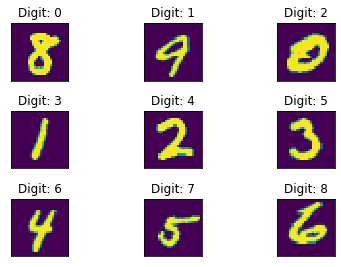

In [ ]:
print_first_9(all_data[-9:])

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Reshape, Conv2D, MaxPool2D, UpSampling2D
from keras.models import Model
import keras.backend as K
from keras.optimizers import SGD

In [ ]:
# Print inputs and outputs helper methods
def reconstruct(model):
  n_images=10
  decoded_imgs = model.predict(X_test[:n_images])
  plt.figure(figsize=(20, 4))
  for i in range(n_images):
    # plot original
    plt.subplot(2, n_images, 1 + i)
    plt.imshow(X_test[i].reshape(28, 28), cmap="binary")
    plt.axis("off")
    # plot decoded
    plt.subplot(2, n_images, 1 + n_images + i)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap="binary")
    plt.axis("off")

In [ ]:
# Normalize data
max_value = float(X_train.max())

X_train = X_train.astype(np.float32) / max_value
X_test = X_test.astype(np.float32) / max_value

X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

## 1. Stacked 784 - 392 - 196 - 392 - 784 (tied weights)

In [ ]:
# Custom layer for transposed weights
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [ ]:
# Tied Weights
K.clear_session()

# Tied weights
dense_1 = Dense(784, activation="selu")
dense_2 = Dense(392, activation="selu")
dense_3 = Dense(196, activation="selu")

# Encoder
input = keras.Input(shape=(28,28))
flattened = keras.layers.Flatten()(input)
encoder_l1 = dense_1(flattened)
encoder_l2 = dense_2(encoder_l1)
encoded = dense_3(encoder_l2)

# Decoder
decoder_l1 = DenseTranspose(dense_3, activation="relu")(encoded)
decoder_l2 = DenseTranspose(dense_2, activation="relu")(decoder_l1)
decoder_l3 = DenseTranspose(dense_1, activation="sigmoid")(decoder_l2)
decoded = Reshape([28, 28])(decoder_l3)

# Model
tied_ae = Model(input, decoded)
tied_ae.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 784)               615440    
_________________________________________________________________
dense_1 (Dense)              (None, 392)               307720    
_________________________________________________________________
dense_2 (Dense)              (None, 196)               77028     
_________________________________________________________________
dense_transpose (DenseTransp (None, 392)               77420     
_________________________________________________________________
dense_transpose_1 (DenseTran (None, 784)              

In [ ]:
# Compile and Train
tied_ae.compile(
  loss="binary_crossentropy", 
  optimizer=SGD(lr=1.5), 
  metrics=['accuracy']
)
history = tied_ae.fit(X_train, X_train, epochs=20, validation_data=[X_test, X_test], verbose=0)

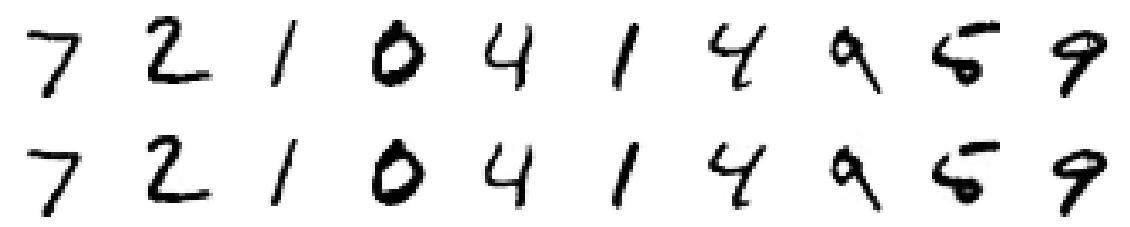

In [ ]:
# Plot
reconstruct(tied_ae)

## Convolutional Encoder (conv, maxpool, conv, maxpool, conv, maxpool). Decoder (conv, upsample2d, conv, upsample2d, conv, upsample2d, conv)

In [ ]:
# Convolutional model
K.clear_session()

# Encoder
input = keras.Input(shape=(28,28))
reshaped = Reshape([28, 28, 1])(input)
e_conv2d_1 = Conv2D(16, (3, 3), activation="selu", padding="same")(reshaped)
e_maxpool2d_1 = MaxPool2D((2, 2), padding="same")(e_conv2d_1)
e_conv2d_2 = Conv2D(8, (3, 3), activation="relu", padding="same")(e_maxpool2d_1)
e_maxpool2d_2 = MaxPool2D((2, 2), padding="same")(e_conv2d_2)
e_conv2d_3 = Conv2D(8, (3, 3), activation="relu", padding="same")(e_maxpool2d_2)
encoded = MaxPool2D((2, 2), padding="same")(e_conv2d_3)

# Decoder
d_conv2d_1 = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
d_maxpool2d_1 = UpSampling2D((2, 2))(d_conv2d_1)
d_conv2d_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(d_maxpool2d_1)
d_maxpool2d_2 = UpSampling2D((2, 2))(d_conv2d_2)
d_conv2d_3 = Conv2D(16, (3, 3), activation='relu')(d_maxpool2d_2)
d_maxpool2d_3 = UpSampling2D((2, 2))(d_conv2d_3)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d_maxpool2d_3)

# Model
convolutional_ae = Model(input, decoded)
convolutional_ae.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)          

In [ ]:
# Compile and Model
convolutional_ae.compile(
  loss='binary_crossentropy',
  optimizer='adam', 
  metrics=['accuracy']
)
convolutional_ae.fit(
  X_train, X_train,
  epochs=10,
  validation_data=(X_test, X_test),
  verbose=0
)

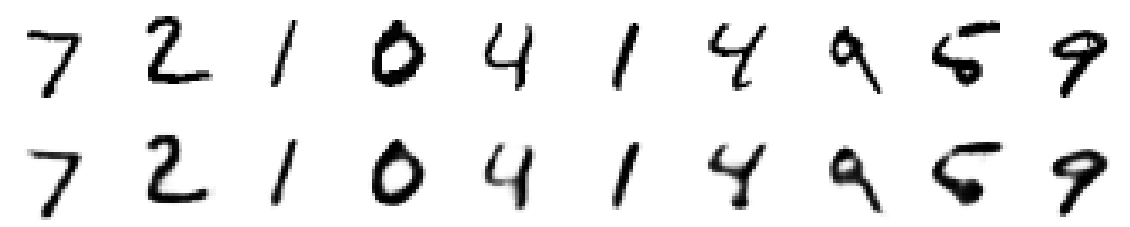

In [ ]:
# Plot
reconstruct(convolutional_ae)